<a href="https://www.kaggle.com/code/vnniciusgabriel/tabular-tabular-kidney-stone?scriptVersionId=229181438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import wraps
from time import perf_counter
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis, pearsonr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

__import__('warnings').filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')

# Exploratory Data Analysis (EDA)

## 1. Variable Identification

In [3]:
df_train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


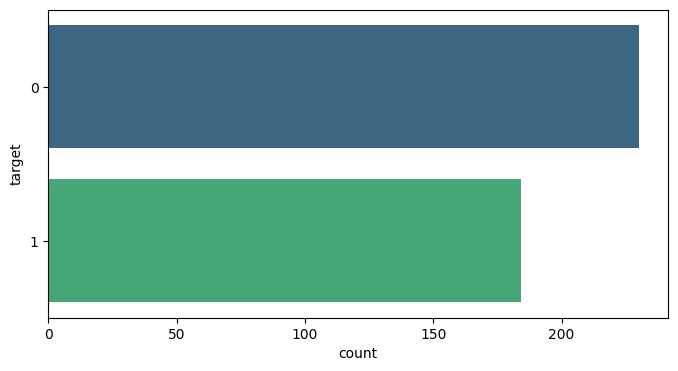

In [5]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.countplot(y='target', data=df_train, palette='viridis')
plt.show()

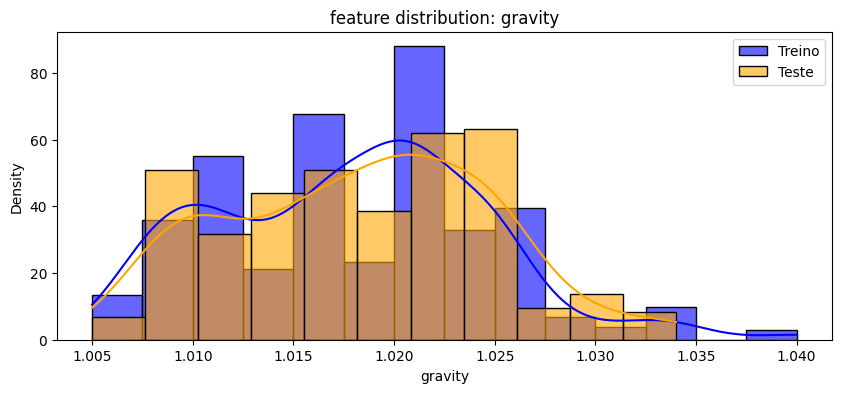

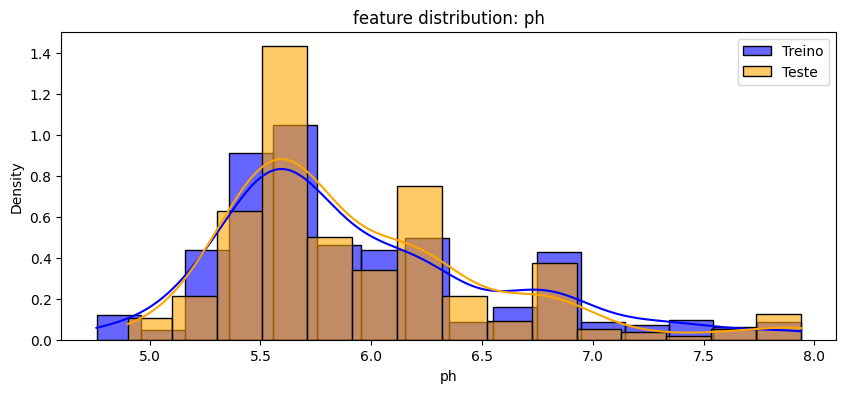

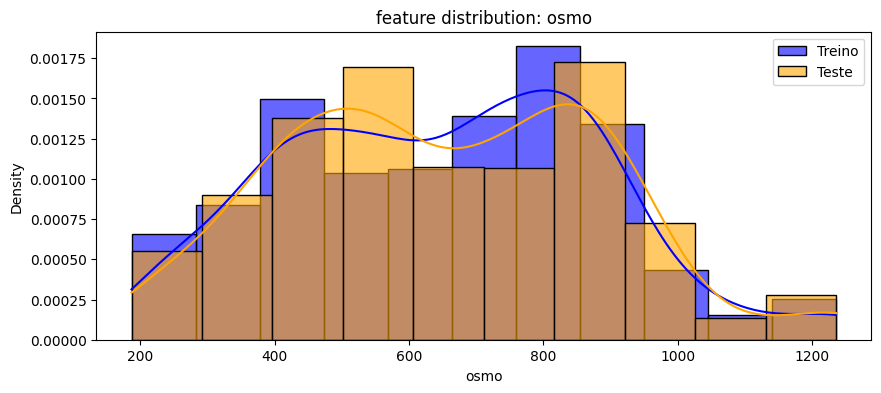

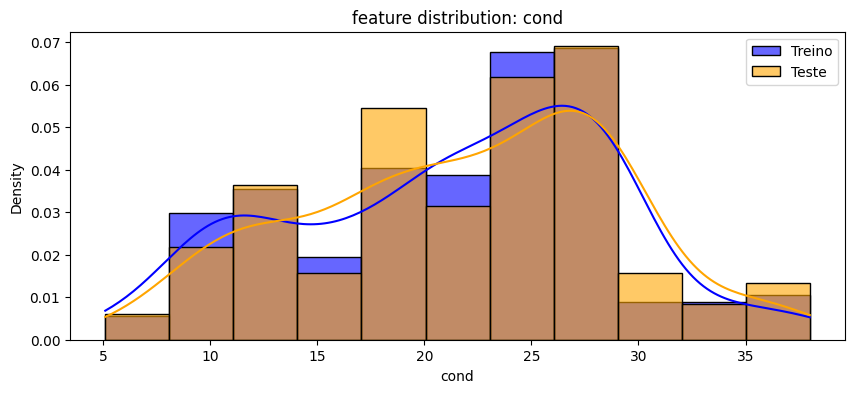

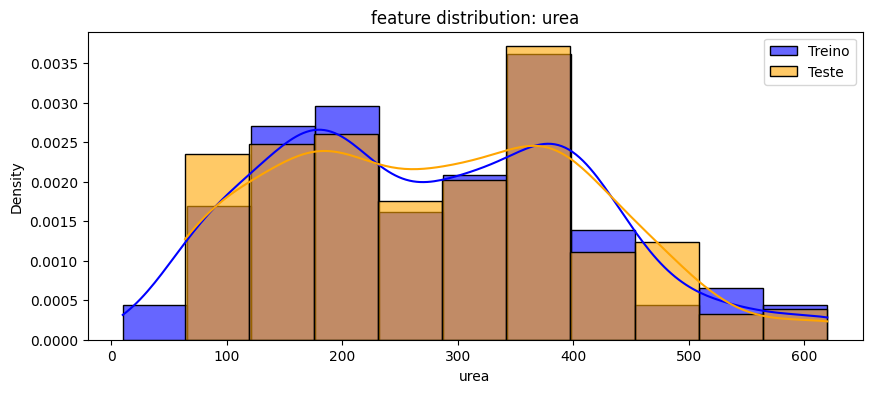

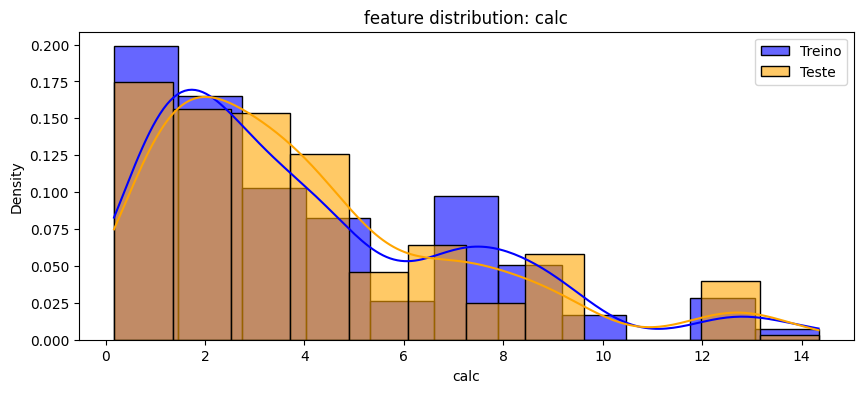

In [6]:
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

for feature in features:
    plt.figure(figsize=(10, 4))
    
    sns.histplot(df_train[feature], color='blue', kde=True, stat="density", label='Treino', alpha=0.6)
    
    sns.histplot(df_test[feature], color='orange', kde=True, stat="density", label='Teste', alpha=0.6)
    
    plt.title(f'feature distribution: {feature}')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

## 2. Univariate Analysis

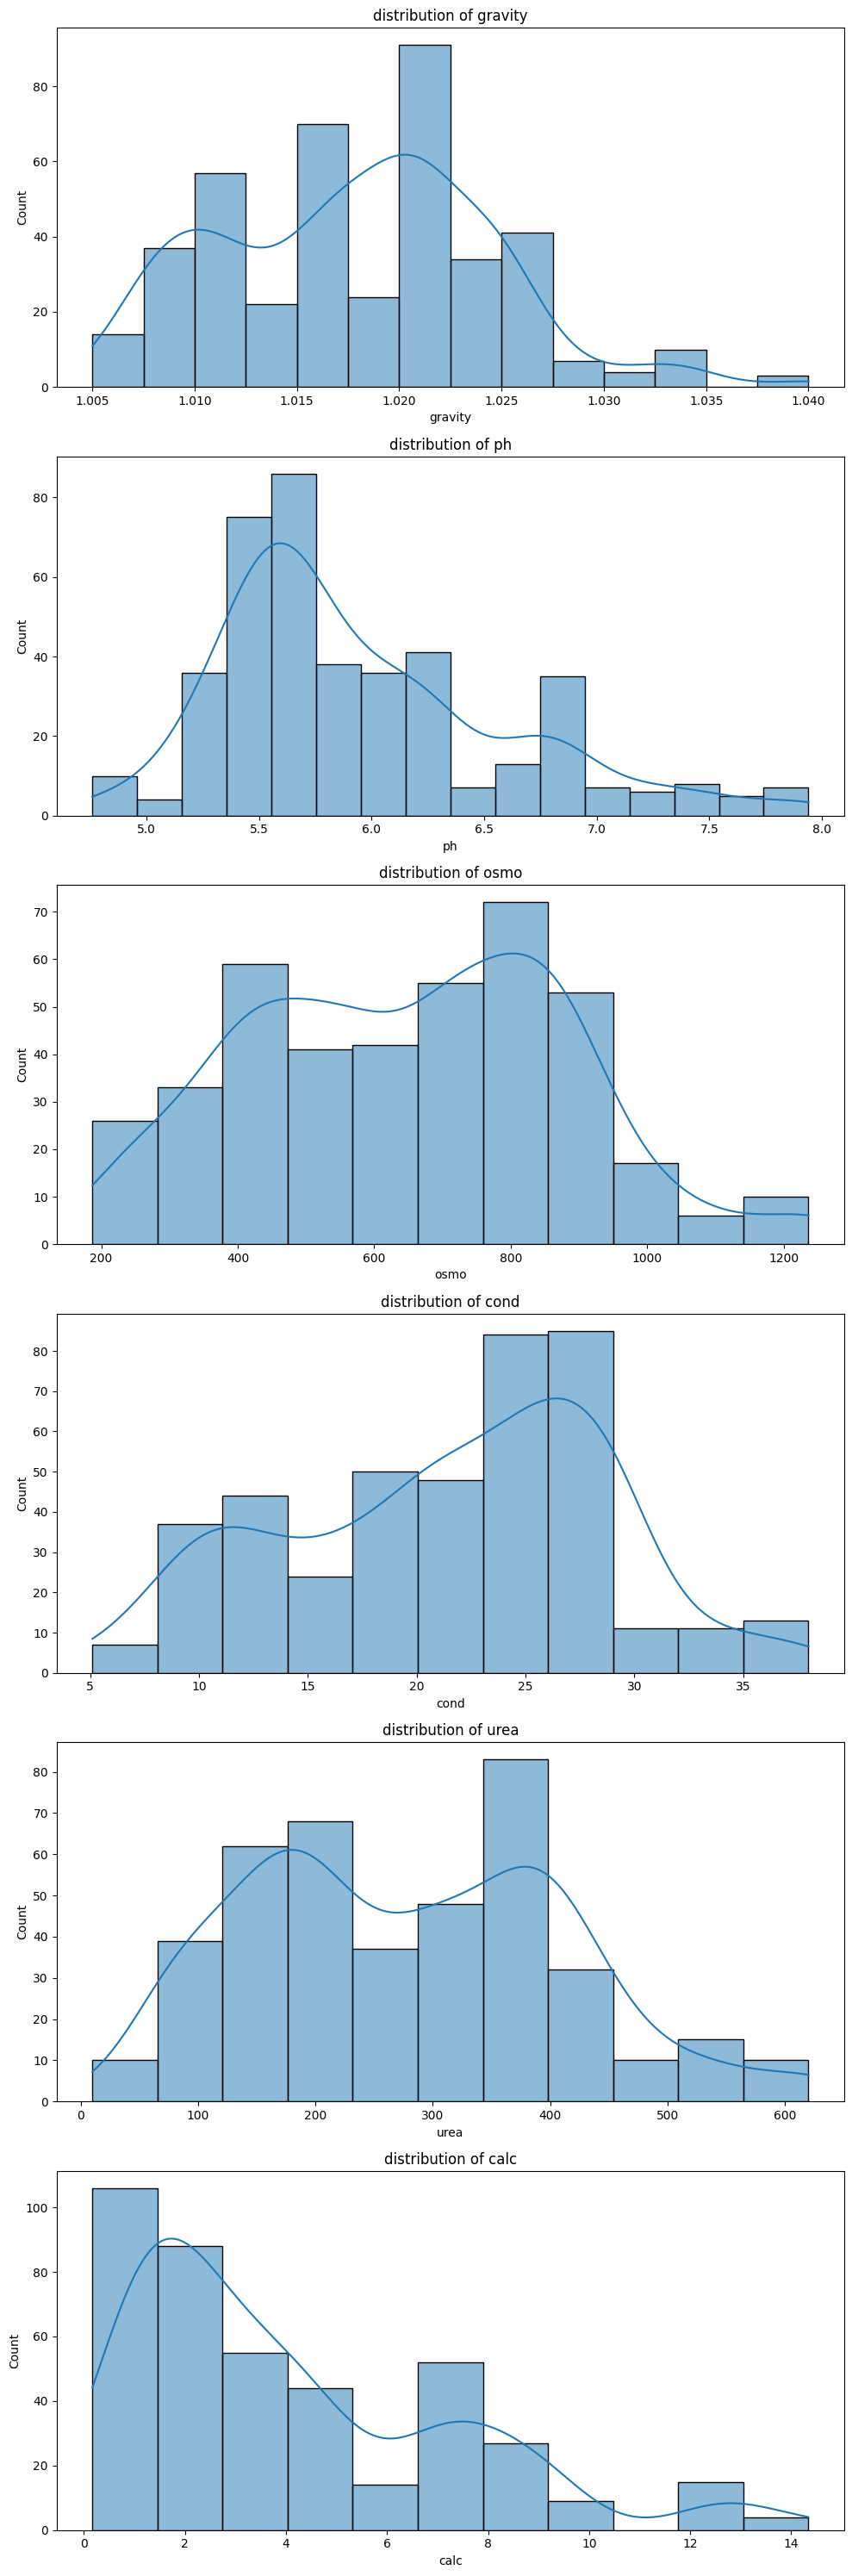

In [7]:
fig, axs = plt.subplots(nrows=len(features), figsize=(10, 5 * len(features)))
for i, var in enumerate(features):
    sns.histplot(df_train[var], kde=True, ax=axs[i])
    axs[i].set_title(f'distribution of {var}')
plt.tight_layout()
plt.show()

## 3. Bivariate Analysis

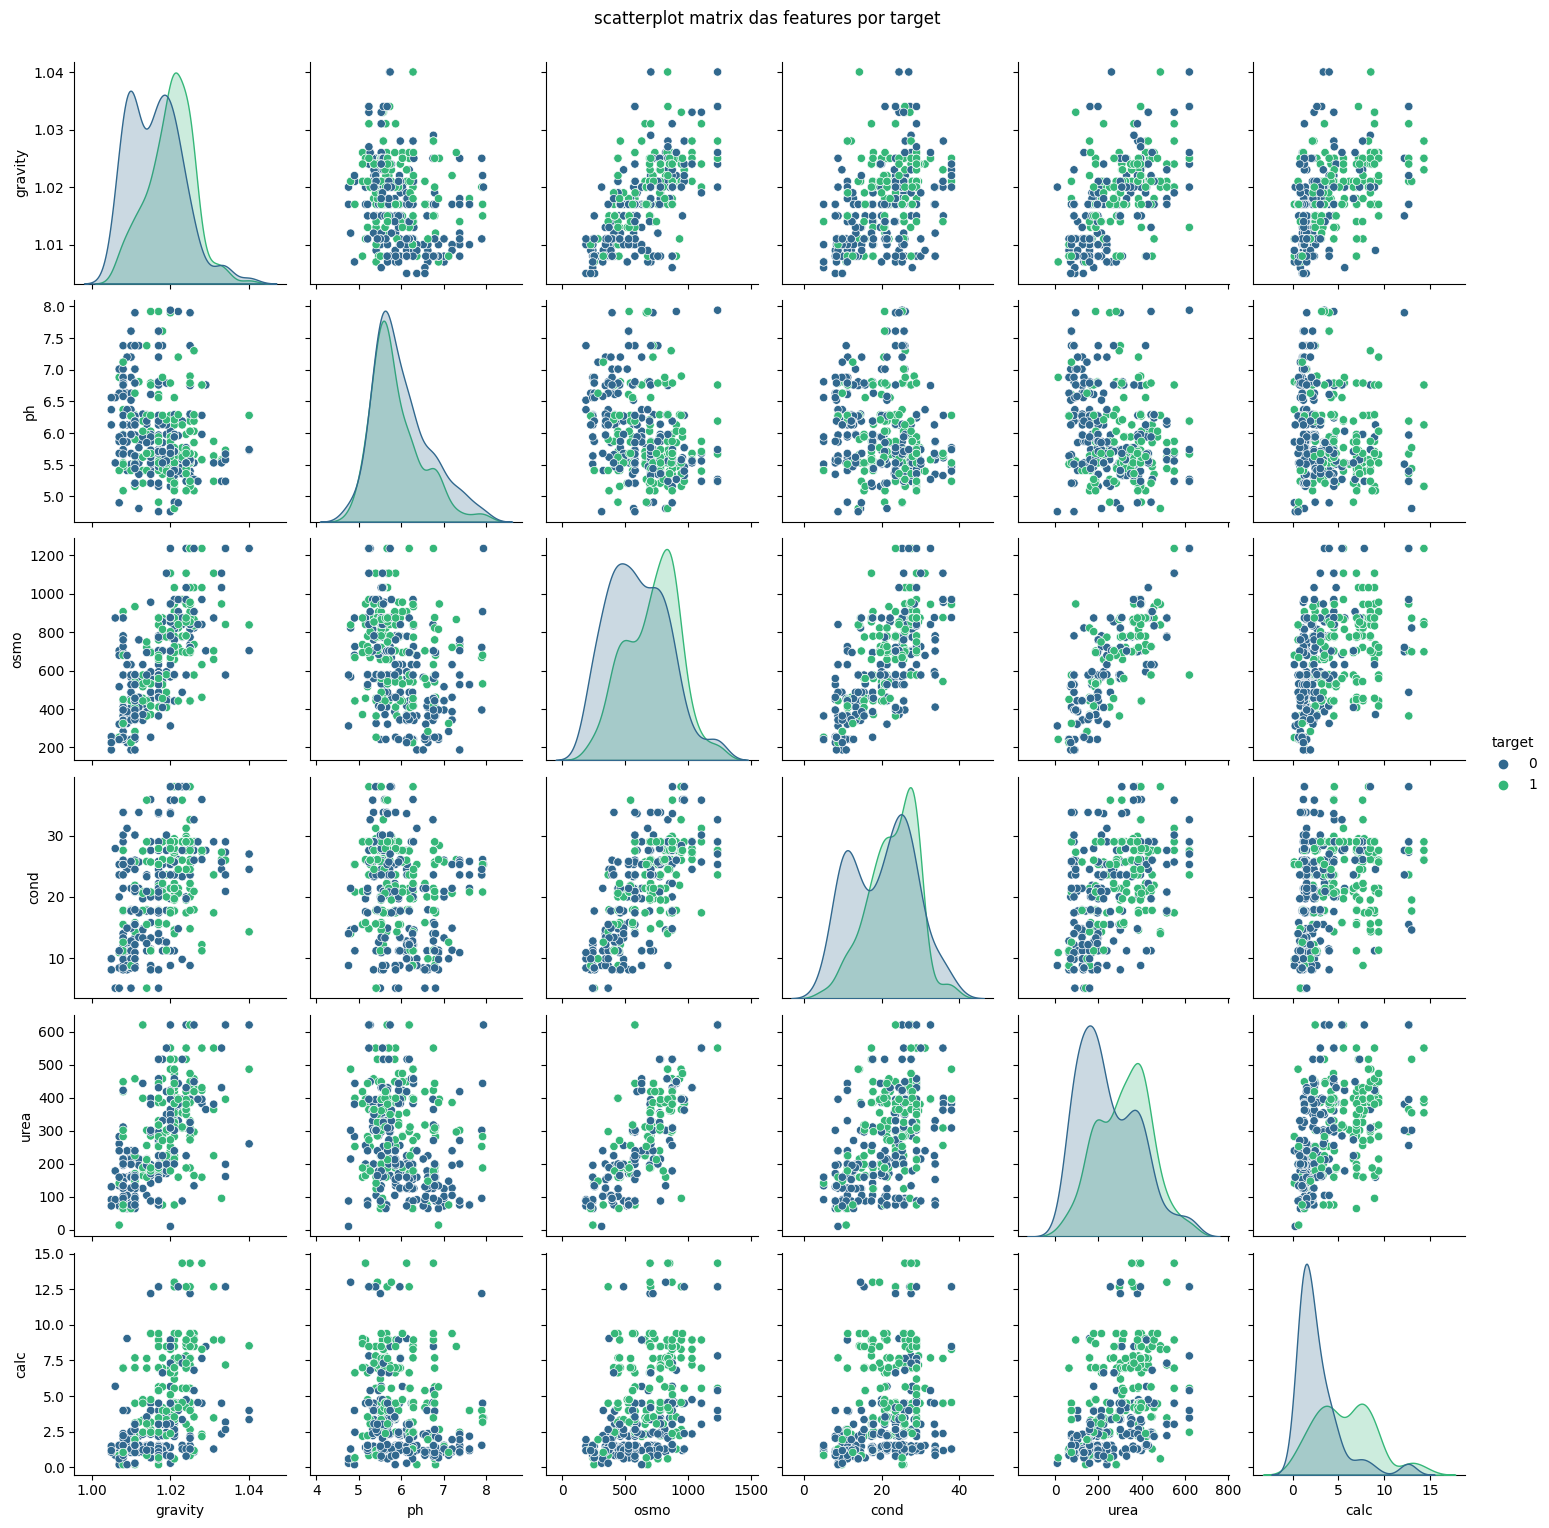

In [8]:
sns.pairplot(df_train, vars=features, hue='target', palette='viridis', diag_kind='kde')
plt.suptitle("scatterplot matrix das features por target", y=1.02)
plt.show()

## 4. Outlier Detection and Treatment

In [9]:
def treat_outliers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    for var in features:
    
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[var], color='skyblue')
        plt.title(f'before treatment: {var}')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
        outliers = df[(df[var] < lower) | (df[var] > upper)]
        print(f"{var}: {len(outliers)} outliers detected")
    
        df[var] = np.where(df[var] < lower, lower, np.where(df[var] > upper, upper, df[var]))
    
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[var], color='lightgreen')
        plt.title(f"after treatment: {var}")
        plt.grid(True, linestyle='--', alpha=0.7)
    
        plt.tight_layout()
        plt.show()

    return df

gravity: 3 outliers detected


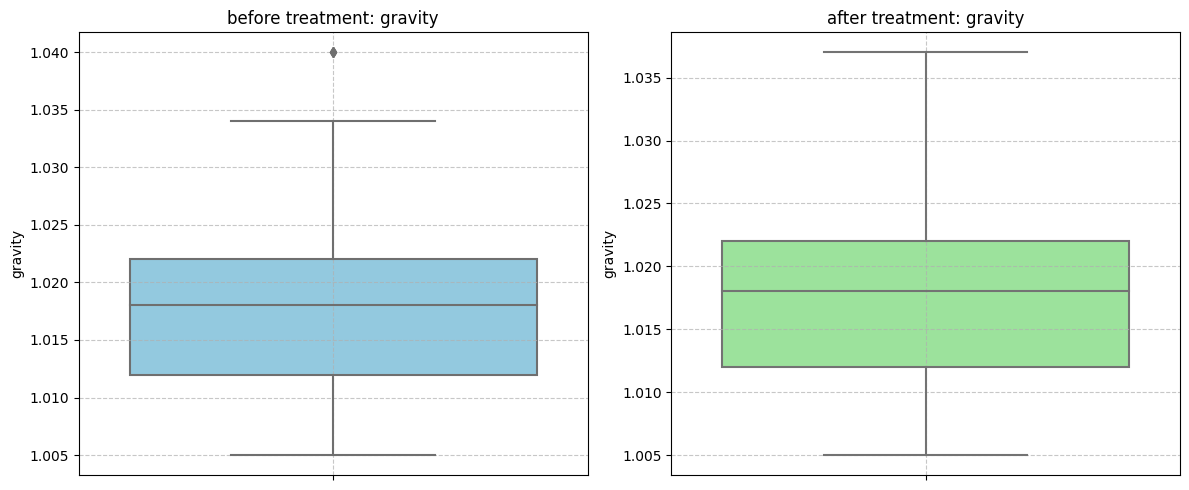

ph: 12 outliers detected


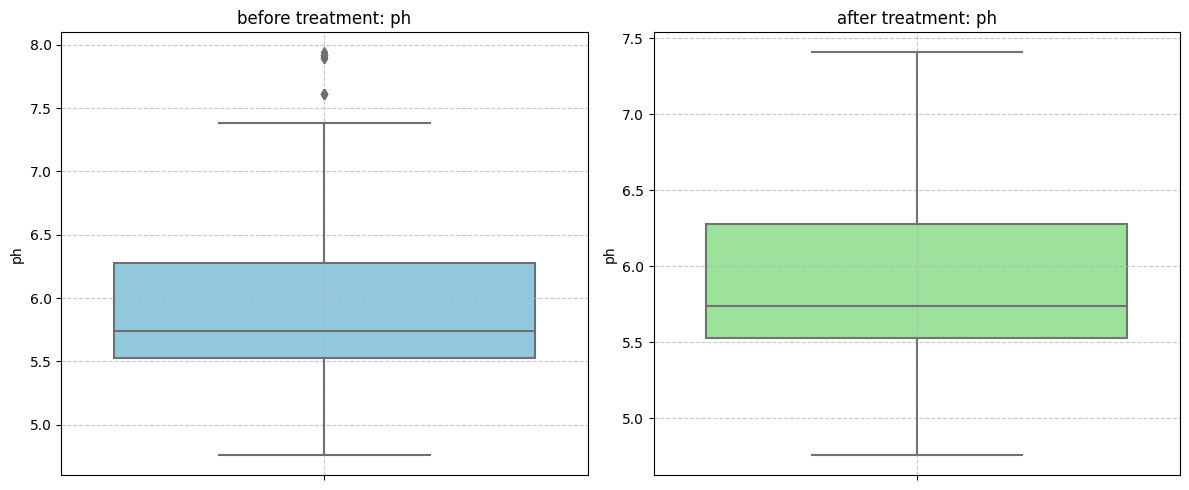

osmo: 0 outliers detected


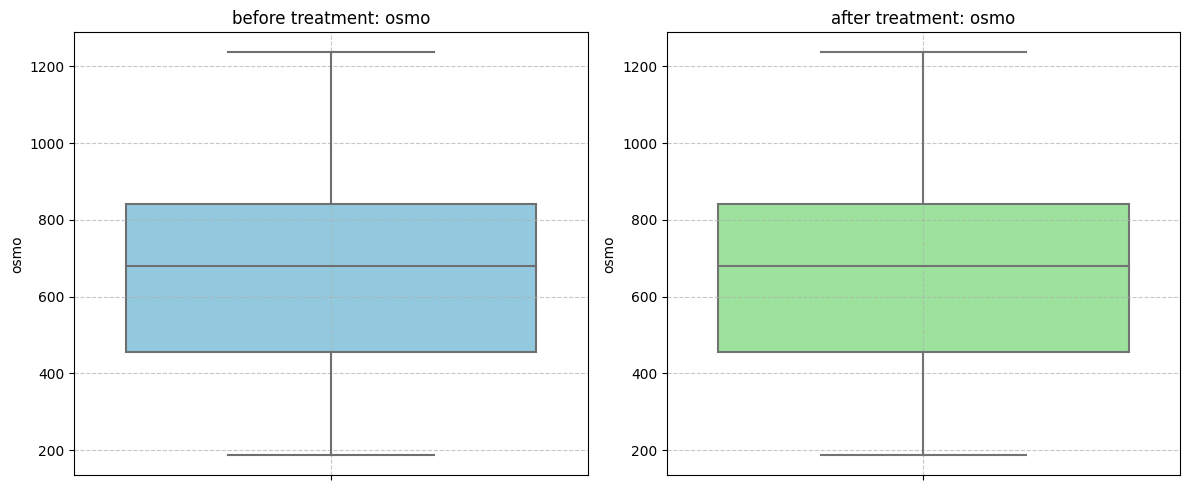

cond: 0 outliers detected


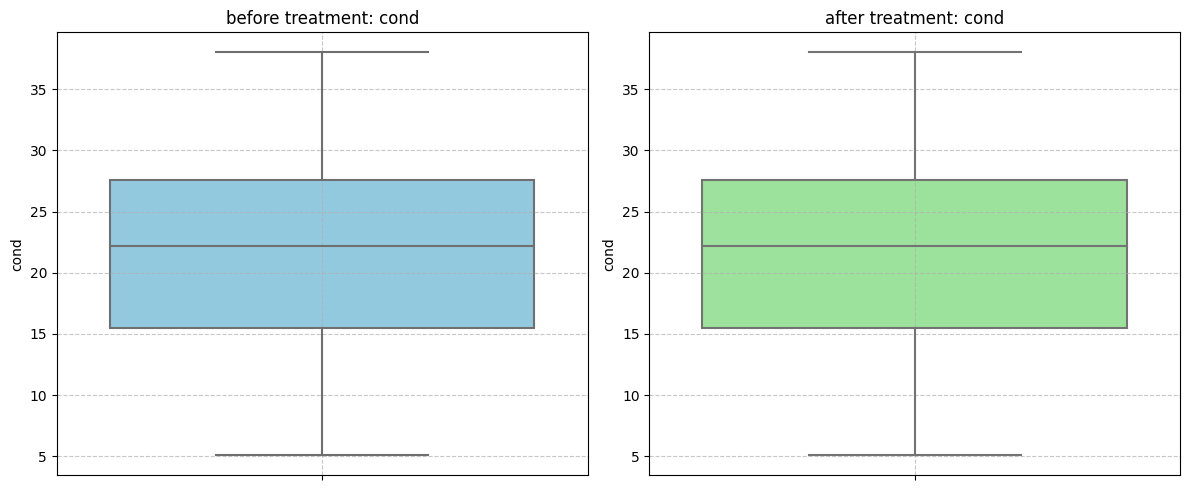

urea: 0 outliers detected


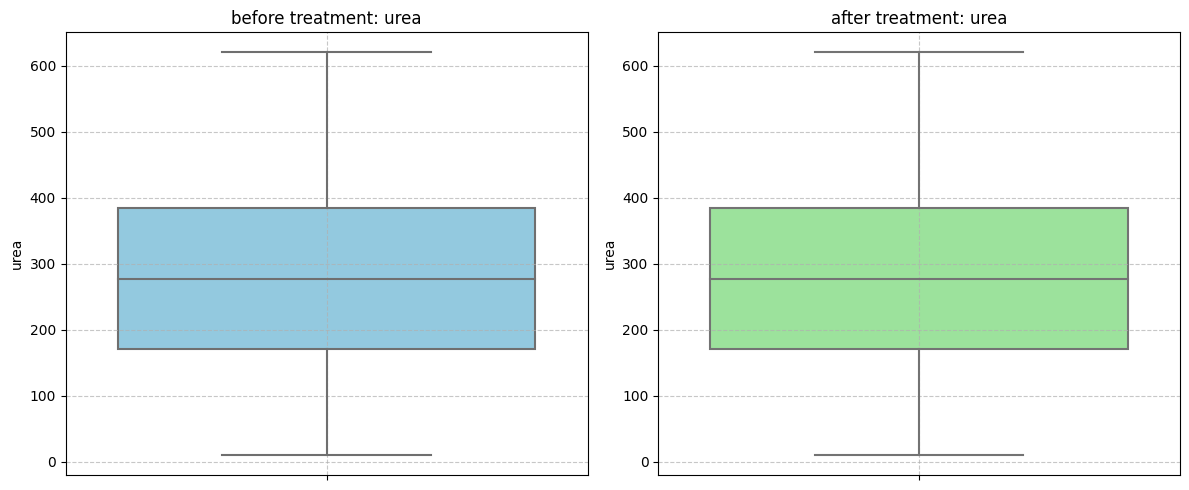

calc: 0 outliers detected


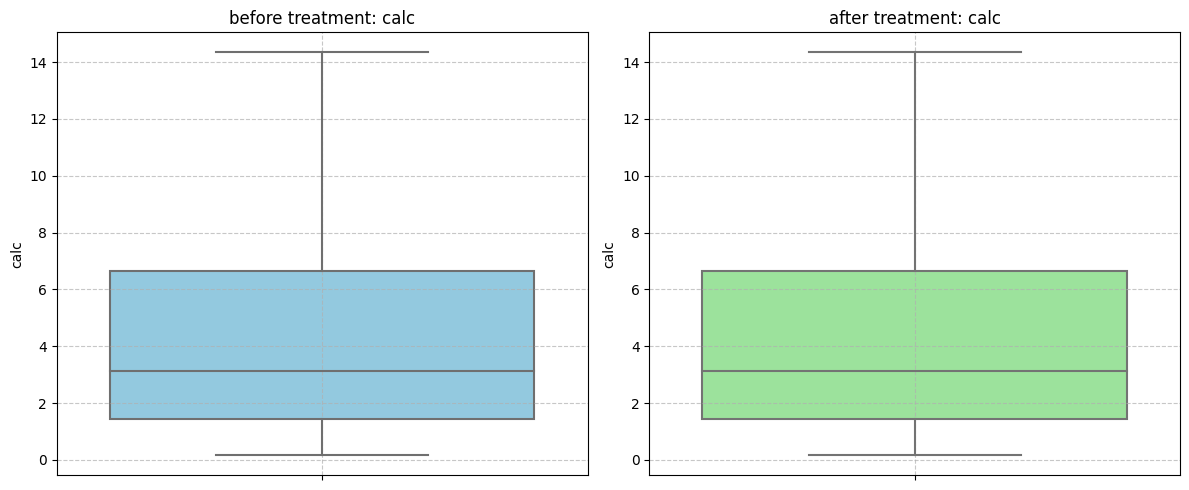

In [10]:
df_train_without_outliers = treat_outliers(df_train)

gravity: 0 outliers detected


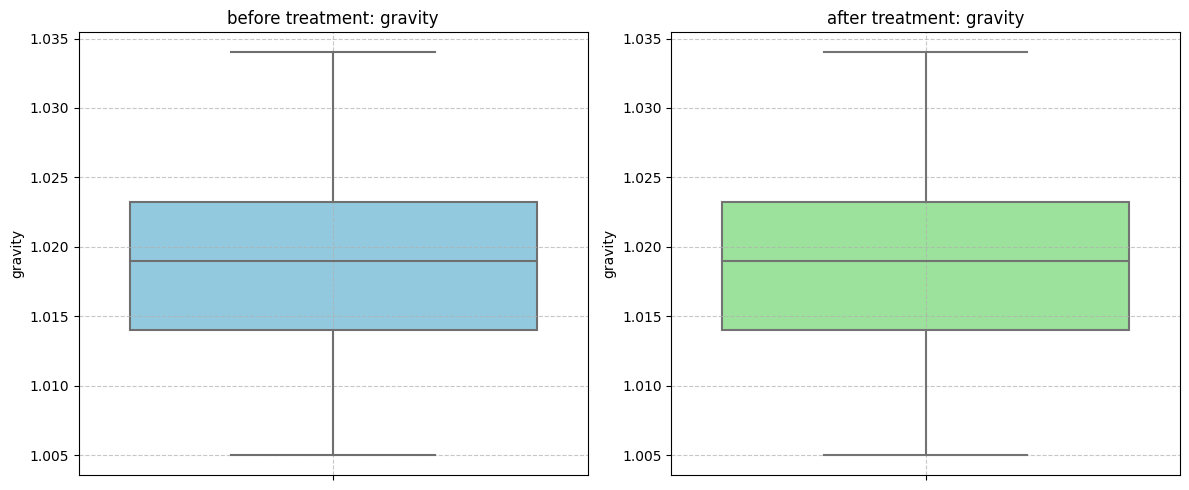

ph: 11 outliers detected


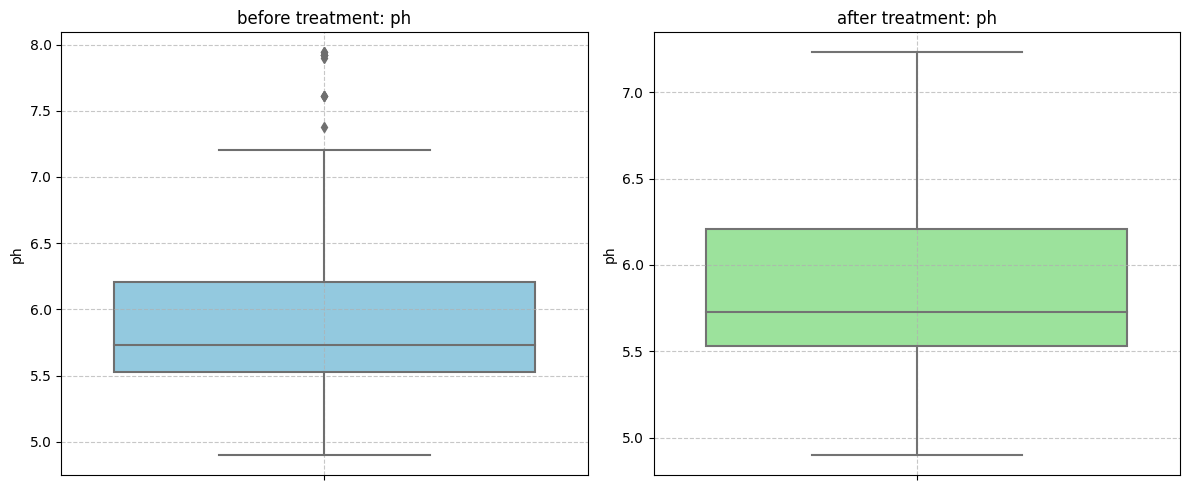

osmo: 0 outliers detected


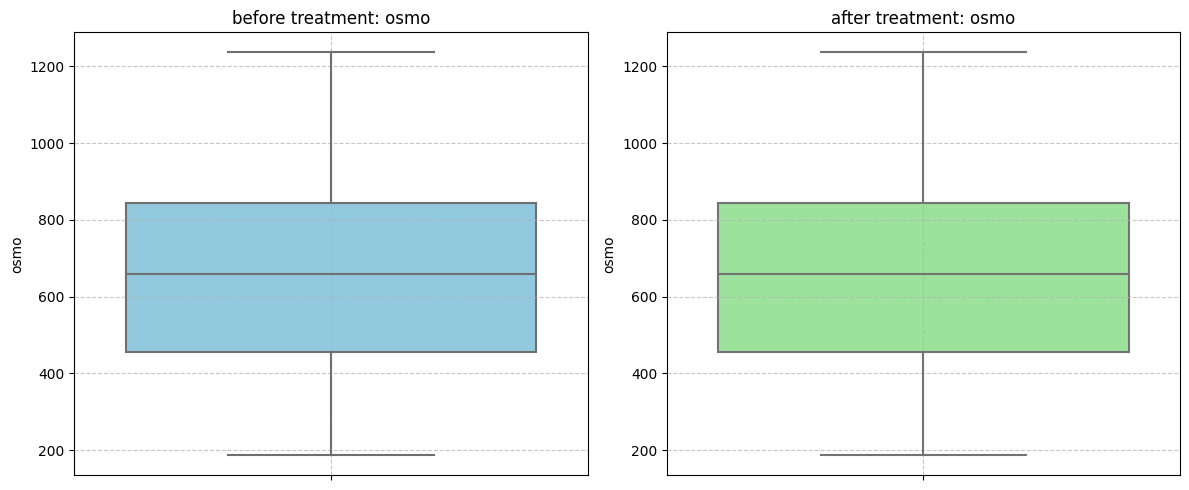

cond: 0 outliers detected


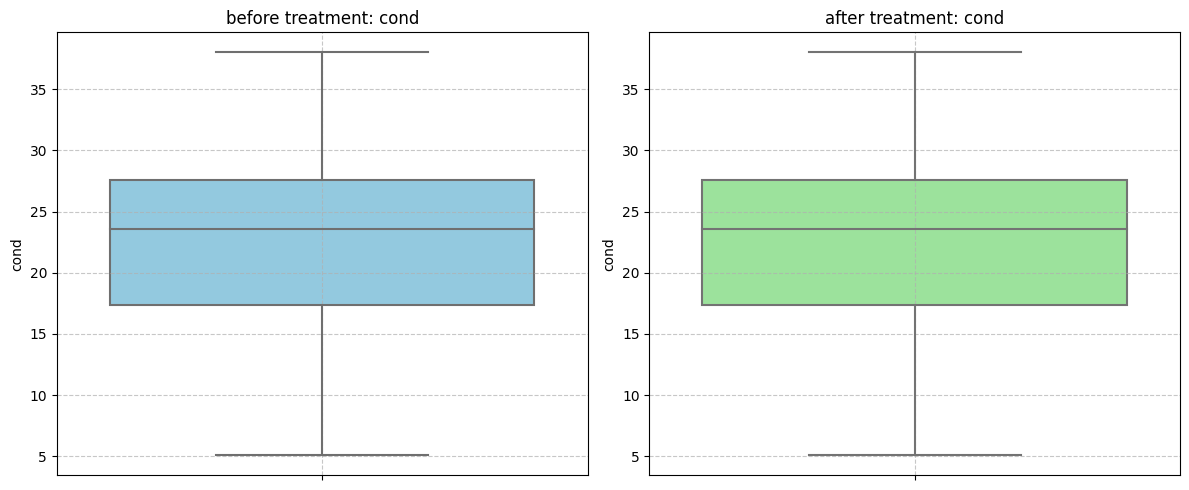

urea: 0 outliers detected


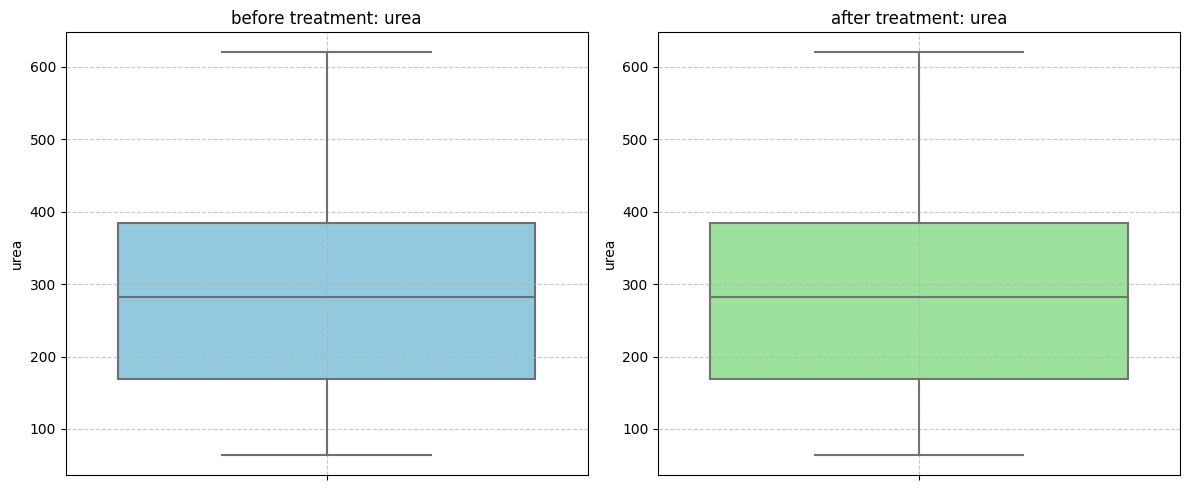

calc: 14 outliers detected


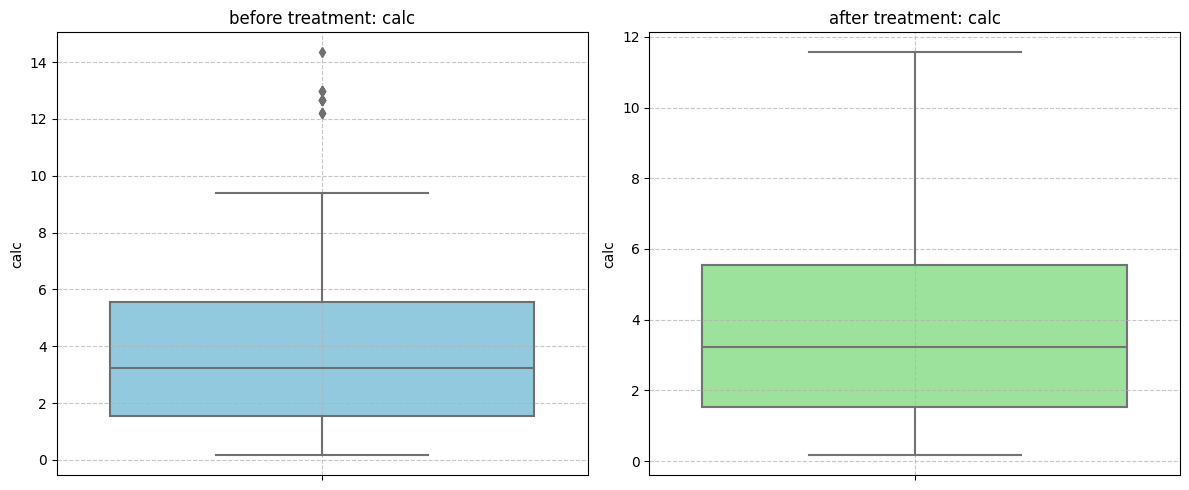

In [11]:
df_test_without_outliers = treat_outliers(df_test)

## 5. Data Cleaning and Transformation

In [12]:
pipeline = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]
)

X, y = pipeline.fit_transform(df_train_without_outliers[features]), df_train['target']

## 6. Feature Engineering and Selection

top features com scores chi^2


,Feature,Chi2_Score,P_value
26,calc^2,16.754512,0.000043
5,calc,16.714667,0.000043
11,gravity calc,11.382553,0.000741
20,osmo calc,11.350597,0.000754
25,urea calc,11.290134,0.000779
23,cond calc,10.645677,0.001103
16,ph calc,5.727510,0.016701
10,gravity urea,3.937573,0.047219


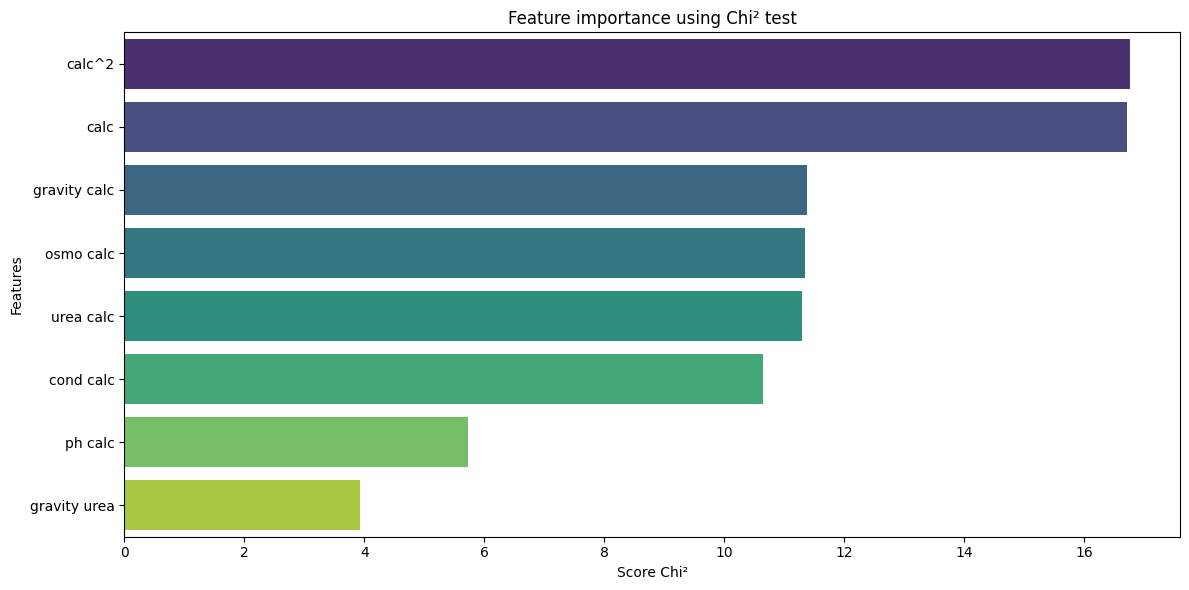

In [13]:
feature_names = pipeline.get_feature_names_out()

selector = SelectKBest(chi2, k=8)
selector.fit(X, y)

features_scores = pd.DataFrame({
    'Feature': feature_names,
    'Chi2_Score': selector.scores_,
    'P_value': selector.pvalues_
})

selected_features = feature_names[selector.get_support()]
selected_features_scores = features_scores.loc[selector.get_support()].sort_values('Chi2_Score', ascending=False)

print("top features com scores chi^2")
display(selected_features_scores.style.background_gradient(cmap='Blues', subset=['Chi2_Score']))

plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2_Score', y='Feature', data=selected_features_scores, palette='viridis')
plt.title('Feature importance using Chi² test')
plt.xlabel('Score Chi²')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 7. Multivariate Analysis

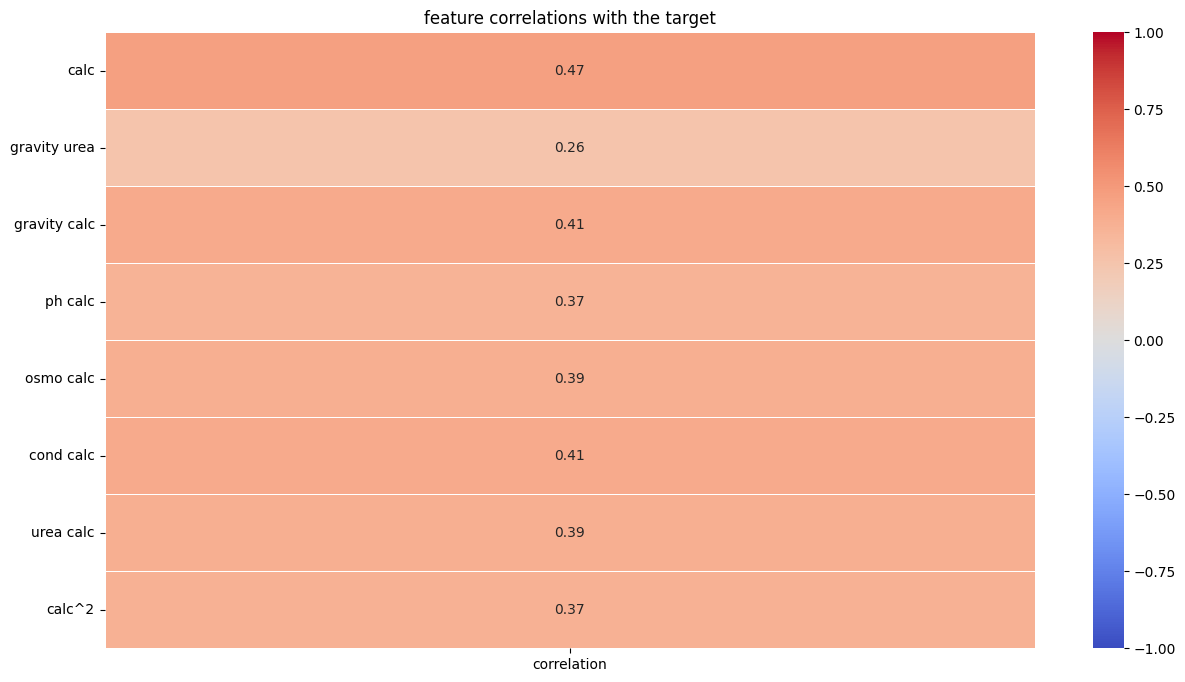

In [14]:
X = pd.DataFrame(X, columns=feature_names)[selected_features]
corr_matrix = X.corrwith(pd.Series(y))

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix.to_frame('correlation'), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('feature correlations with the target')
plt.show()

## 9. Modeling Considerations

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"train size: {len(X_train)}, test_size: {len(X_test)}")

train size: 331, test_size: 83


# Traning and evaluating Model

In [16]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = perf_counter()
        result = func(*args, **kwargs)
        print(f"{func.__name__} took {perf_counter() - start:.2f} seconds")
        return result
    return wrapper

In [17]:
@timeit
def train_model_and_evaluate(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    cm.plot()
    plt.grid(False)
    plt.show()

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        45
           1       0.76      0.74      0.75        38

    accuracy                           0.77        83
   macro avg       0.77      0.77      0.77        83
weighted avg       0.77      0.77      0.77        83



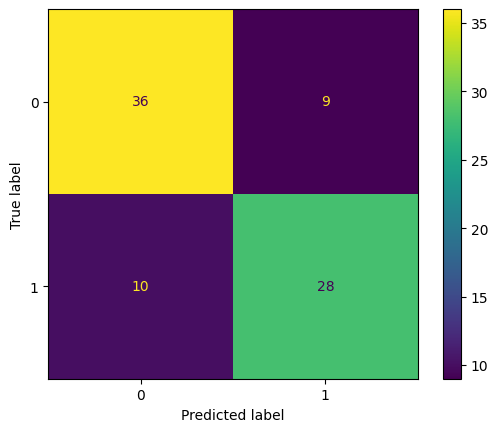

train_model_and_evaluate took 0.21 seconds


In [18]:
train_model_and_evaluate(LogisticRegression(class_weight='balanced'))

# hyperturn logistic regression

best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
best ROC AUC: 0.7801
              precision    recall  f1-score   support

           0       0.81      0.78      0.80        45
           1       0.75      0.79      0.77        38

    accuracy                           0.78        83
   macro avg       0.78      0.78      0.78        83
weighted avg       0.78      0.78      0.78        83



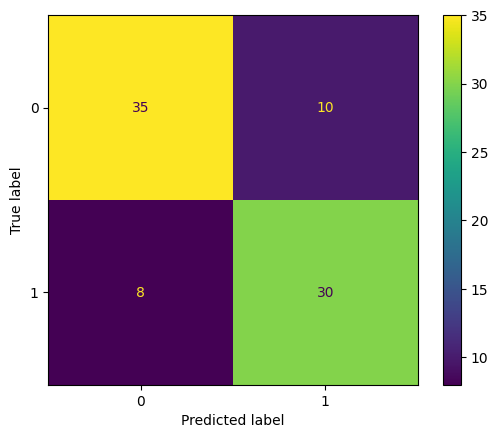

In [19]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("best ROC AUC:", round(grid_search.best_score_, 4))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm.plot()
plt.grid(False)
plt.show()

In [20]:
X = pipeline.transform(df_test_without_outliers[features])
X = pd.DataFrame(X, columns=feature_names)[selected_features]

y_pred = grid_search.predict_proba(X)[:, 1]

df_test_without_outliers['target'] = y_pred
df_test_without_outliers[['id', 'target']].to_csv('/kaggle/working/submission.csv', index=False)